In [2]:
import math
from numbers import Number
from itertools import chain

import momepy
import geopandas as gpd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=False)

import numpy as np
import torch
import torch.nn.functional as F
from scipy.sparse.csgraph import shortest_path
from sklearn.metrics import roc_auc_score
from torch.nn import BCEWithLogitsLoss, Conv1d, MaxPool1d, ModuleList

from torch_geometric.data import Data, Batch, InMemoryDataset, download_url, extract_zip
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomLinkSplit, OneHotDegree
from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix

from train import run, run_single, run_all
from utils.load_geodata import load_gdf, load_graph
from utils.utils import mean_curves
from utils.constants import project_root, dataset_root
from utils.constants import rank_fields, log_fields, all_feature_fields, included_places, geom_feats
from utils.valid_edge import is_valid
from utils.visualization import plot_roc_pr, plot_multiple_roc_pr

print(f'SSx metrics of {len(included_places)} local authorities retrieved')
!nvidia-smi

SSx metrics of 348 local authorities retrieved
Tue Jun  7 14:17:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   26C    P8     7W / 180W |   1735MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                         

## Train on multiple LAs and test on a hold-out set of LAs

In [4]:
# dataset_clean_sum = torch.load(f'{dataset_root}/ssx_dataset_clean_sum.pt')
# dataset_clean_mean = torch.load(f'{dataset_root}/ssx_dataset_clean_mean.pt')
# dataset_clean_max = torch.load(f'{dataset_root}/ssx_dataset_clean_max.pt')
dataset_clean_median = torch.load(f'{dataset_root}/ssx_dataset_clean_median.pt')
dataset_clean_std = torch.load(f'{dataset_root}/ssx_dataset_clean_std.pt')

result_dict = {}
# for var_str, var in {
#     'median': dataset_clean_median,
#     'std': dataset_clean_std
# }.items():
#     model_args = {
#         'out_channels': 10,
#         'model_type': 'gain',
#         'num_layers': 2,
#         'distmult': True,
#     }
#     proc_args = {
#         'include_feats': ['integration2kmrank', 'integration10kmrank'],
#         'add_deg_feats': False
#     }
#     models, results = run(var,
#                         proc_args,
#                         model_args,
#                         num_iter=5,
#                         lr=0.001,
#                         epochs=500,
#                         schedule_lr=False,
#                         output_tb=False,
#                         save_best_model=False)
#     result_dict[var_str] = results
# torch.save(dict_res, './run_results_16_04_22.pt')
dataset_clean_median[0].x

tensor([[5.8421e+01, 3.3500e+02, 1.2000e+02,  ..., 2.5575e+00, 4.6289e+05,
         9.0926e+04],
        [1.0817e+02, 0.0000e+00, 1.2000e+02,  ..., 0.0000e+00, 4.6300e+05,
         9.0900e+04],
        [1.5749e+02, 1.8590e+03, 1.2300e+02,  ..., 6.1100e+00, 4.6050e+05,
         8.6571e+04],
        ...,
        [3.9648e+02, 1.3150e+03, 7.3900e+02,  ..., 8.2942e+00, 4.5959e+05,
         9.1221e+04],
        [2.6954e+02, 4.1900e+02, 4.4200e+02,  ..., 3.9966e+00, 4.5963e+05,
         8.4970e+04],
        [1.9765e+02, 4.5800e+02, 4.7800e+02,  ..., 3.9966e+00, 4.5978e+05,
         8.4938e+04]], dtype=torch.float64)

## Train on a single LA's graph and test against all others

In [ ]:
dataset = torch.load(f'{dataset_root}/ssx_dataset_min.pt')
places = ['Coventry']

model_params = {
    'model_type': 'gain',
    'distmult': True,
    'out_channels': 10
}
run_hyperparams = {
    'seed': 42,
    'model_args': model_params,
    'num_iter': 5,
    'lr': 0.01,
    'epochs': 2000,
    'print_every': 10,
    'add_deg_feats': False,
    'schedule_lr': True,
    'include_feats': ['integration2kmrank', 'integration10kmrank'],
}
run_single(places, dataset, run_args=run_hyperparams, only_transductive=True)

# Train on all LAs and test on each one

In [ ]:
dataset_clean_sum = torch.load(f'{dataset_root}/ssx_dataset_clean_dual_max.pt')
dataset_clean_mean = torch.load(f'{dataset_root}/ssx_dataset_clean_dual_sum.pt')
dataset_clean_max = torch.load(f'{dataset_root}/ssx_dataset_clean_dual_max.pt')
result_dict = {}
for i, var in enumerate([
    dataset_mean
]):
    model_params = {
        'model_type': 'gain',
        'out_channels': 10,
        'num_layers': 2,
        'distmult': True,
    }

    run_hyperparams = {
        'seed': 42,
        'model_args': model_params,
        'num_iter': 5,
        'lr': 0.01,
        'epochs': 1000,
        'print_every': 10,
        'add_deg_feats': False,
        'batch_size': 8,
        'include_feats': rank_fields,
    }
    data = run_all(var, run_args=run_hyperparams)
    result_dict[i] = data

# Train on a single LA's graph and obtain filtered prediction metrics + curves

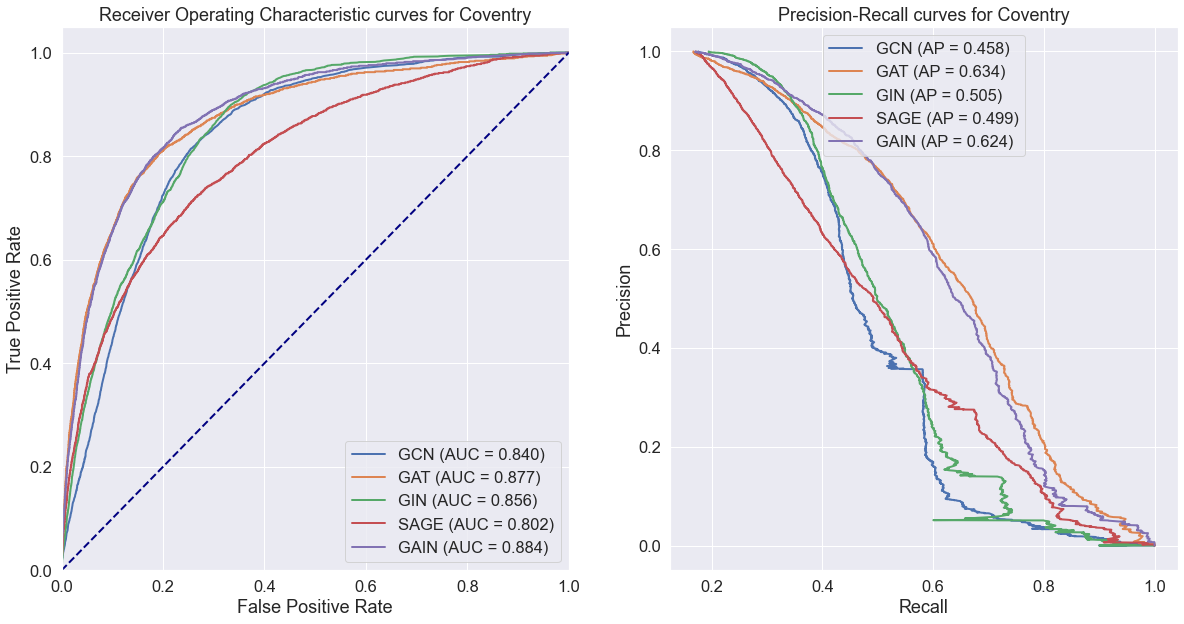

In [9]:
places = ['Coventry']
dataset = torch.load(f'{dataset_root}/ssx_dataset_clean_min.pt')
# result_dict = {}
# for model_type in [
#     'gcn',
#     'gat',
#     'gin',
#     'sage',
#     'gain'
# ]:
#     model_params = {
#         'model_type': model_type,
#         'distmult': True,
#         'out_channels': 10
#     }
#     run_hyperparams = {
#         'seed': 42,
#         'model_args': model_params,
#         'num_iter': 5,
#         'lr': 0.01,
#         'epochs': 2000,
#         'print_every': 10,
#         'add_deg_feats': False,
#         'schedule_lr': False,
#         'include_feats': ['integration2kmrank', 'integration10kmrank'],
#     }
#     results = run_single(places, dataset, run_args=run_hyperparams, only_transductive=True)
#     result_dict[model_type] = results
# result_dict

def plot_multiple_roc_pr(place, rocs, prs):
    f, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot ROC curves
    ax = axs[0]
    for fpr, tpr, label, auc in rocs:
        ax.plot(
            fpr,
            tpr,
            lw=2,
            label=f'{label.upper()} (AUC = {auc:.3f})',
        )
        
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f'Receiver Operating Characteristic curves for {place}')
    ax.legend(loc="lower right")
    
    # Plot PR
    # Obtain curve corresponding to the best AP
    ax = axs[1]
    for prec, rec, label, ap in prs:
        ax.plot(
            prec,
            rec,
            lw=2,
            label=f'{label.upper()} (AP = {ap:.3f})',
        )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f'Precision-Recall curves for {place}')
    ax.legend(loc="upper center")
    plt.savefig('auc_pr.png', bbox_inches='tight')
    plt.show()

def mean_curves(curves):
    """Get the average of differently sized curves with max value 1"""
    max_len = max(len(curve) for curve in curves)
    padded_curves = []
    for curve in curves:
        diff = max_len - len(curve)
        last_value = curve[-1]
        padded_curve = np.pad(curve, (0, diff), mode='constant', constant_values=last_value)
        padded_curves.append(padded_curve)
    return np.mean(padded_curves, axis=0), np.std(padded_curves, axis=0)

sns.set(font_scale = 1.5)
place = places[0]
rocs, prs = [], []
for model_type in result_dict:
    result = result_dict[model_type][place]
    avg_auc = sum(result['train_auc']) / len(result['train_auc'])
    avg_ap = sum(result['train_ap']) / len(result['train_ap'])
                
    fpr, fpr_std = mean_curves([roc[0] for roc in result['roc']])
    tpr, tpr_std = mean_curves([roc[1] for roc in result['roc']])
    
    prec, prec_std = mean_curves([pr[0] for pr in result['pr']])
    rec, rec_std = mean_curves([pr[1] for pr in result['pr']])
    rocs.append((fpr, tpr, model_type, avg_auc))
    prs.append((prec, rec, model_type, avg_ap))
plot_multiple_roc_pr(place, rocs, prs)

# Vizualize link prediction on single LAs

Reading SSx OpenMapping dataset, this may take a while...
Loading Westminster from SSx
Finished prediction, rebuilding road network
Finished prediction, rebuilding road network
Reading SSx OpenMapping dataset, this may take a while...
Loading Westminster from SSx
Results
{'tp': 3640, 'tn': 506, 'fp': 247, 'fn': 128}


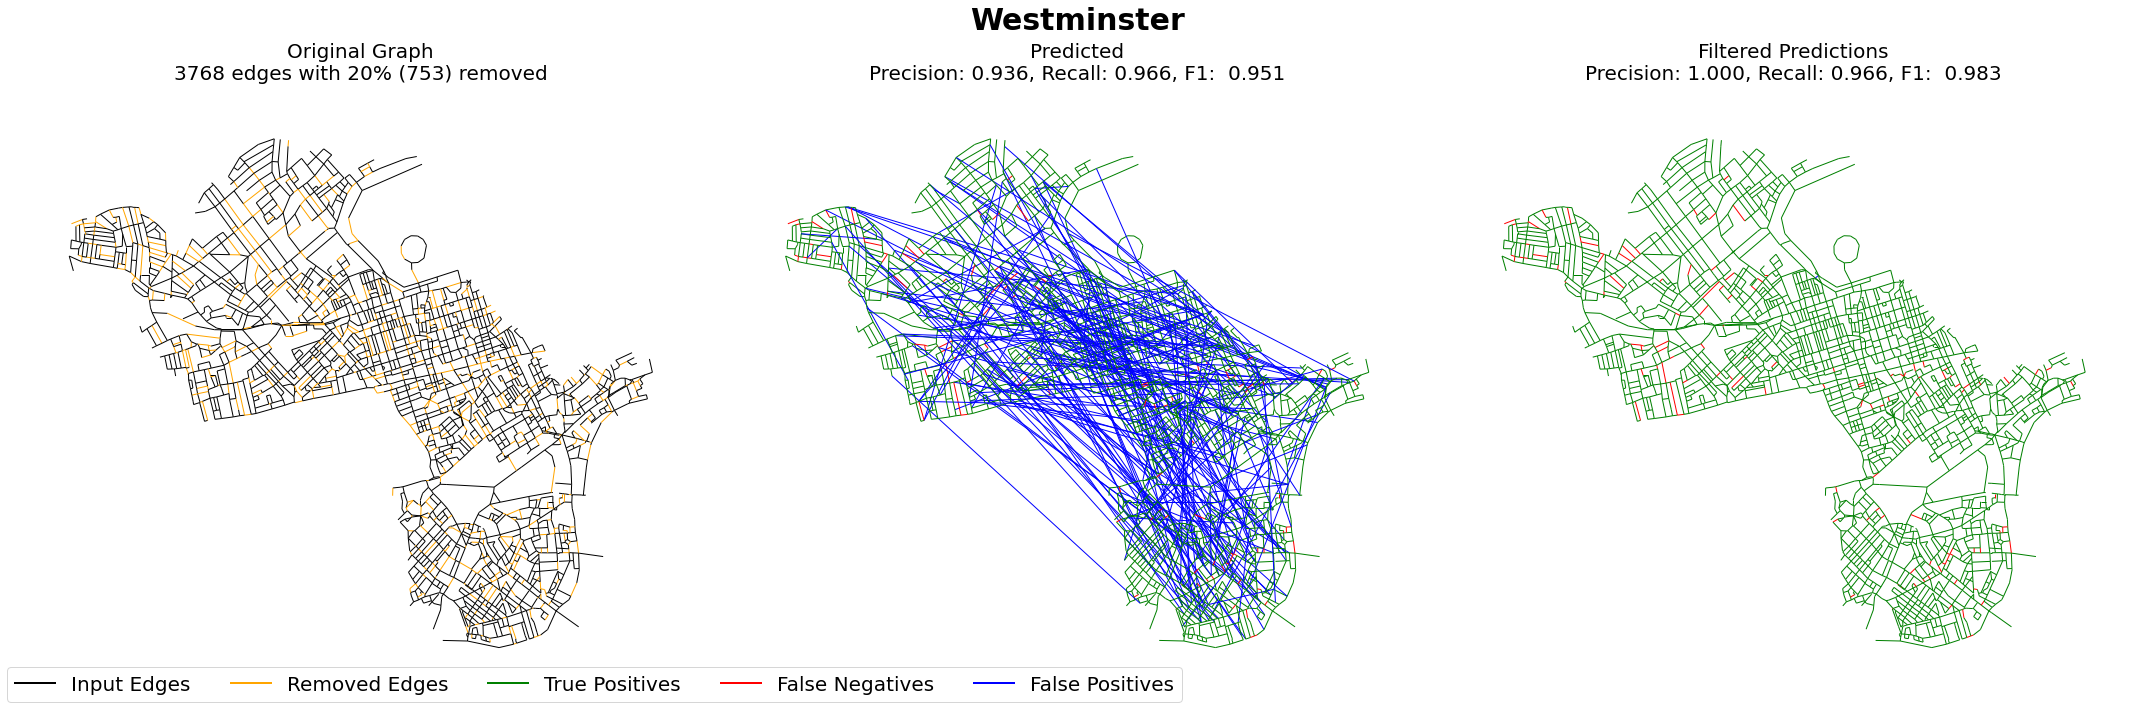

In [6]:
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import copy
from train import process_dataset
from sklearn.metrics import roc_curve
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def predict(model, data, enhanced=True):
    pos_preds, pos_logits = model.predict_pos(data)
    neg_preds, neg_logits = model.predict_neg(data, enhanced=enhanced)
    
    # Create negative and positive labels
    cat_labels = torch.cat([torch.ones(pos_preds.size(0)), torch.zeros(neg_preds.size(0))])
    pos_logits, neg_logits = pos_logits.detach().cpu(), neg_logits.detach().cpu()
    cat_logits = torch.cat([pos_logits, neg_logits] , dim=-1) # TODO
    cat_preds = torch.cat([pos_preds, neg_preds] , dim=-1)
    cat_index = torch.cat([data.edge_index, data.pos_edge_label_index, data.neg_edge_label_index], dim=-1)
    print('Finished prediction, rebuilding road network')
    return cat_preds, cat_labels, cat_index
    
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='orange', lw=2),
                Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='blue', lw=2)]

def visualize_preds(place, model, hold_out_test_ratio=0.2, neg_sampling_ratio=-1):
    original_data = load_graph(place, all_feature_fields, clean=False, reset=True)
    
    data_process_args = {
        'split': 1,
        'hold_out_edge_ratio': hold_out_test_ratio,
        'neg_sampling_ratio': neg_sampling_ratio
    }
    viz_data = process_dataset([original_data], verbose=False, 
                               **data_process_args, **model.data_process_args)[0][0]
    held_out_edges = [(u.item(), v.item()) for u, v in zip(viz_data.pos_edge_label_index[0], viz_data.pos_edge_label_index[1])]
    preds, edge_label, cat_index = predict(model, viz_data, False)
    enhanced_preds, _, _ = predict(model, viz_data, True)
    data = copy.deepcopy(original_data)
    
    res_dict = {} # For storing new edge attributes in nx
    pred_dict = {} # Map of coords to predicted values
    enhanced_res_dict = {} # Map of coords to filtered predicted values
    label_dict = {} # Map of coords to labels (sanity check)
    sampled_dict = {} # For identifying sampled held out edges in plot
    
    gdf = load_gdf(place, clean=False, reset=True)
    streets = momepy.gdf_to_nx(gdf, approach='primal', multigraph=False)
    pred_streets = momepy.gdf_to_nx(gdf, approach='primal', multigraph=False)
    enhanced_pred_streets = momepy.gdf_to_nx(gdf, approach='primal', multigraph=False)
    float32_node_dict = {(torch.tensor(c[0], dtype=torch.float32).item(),
                          torch.tensor(c[1], dtype=torch.float32).item()): c for c in streets}
    count_dict = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    enhanced_count_dict = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
    data = original_data
    
    # Iterate over predicted edges (which includes real and fake edges)
    for i, pred in enumerate(preds):
        enhanced_pred = enhanced_preds[i]

        # Get indices of both the nodes of the edge
        u_idx, v_idx = cat_index[:, i]
        
        # Get their coordinates (the last two node attributes in pretransformed data)
        u_float32 = data.x[u_idx, -2].item(), data.x[u_idx, -1].item()
        v_float32 = data.x[v_idx, -2].item(), data.x[v_idx, -1].item()
        # Convert them into their full precision node coordinates
        u, v = float32_node_dict[u_float32], float32_node_dict[v_float32]
        key = (u, v)
        
        
        if (u_idx, v_idx) in held_out_edges:
            sampled_dict[key] = True
        else:
            sampled_dict[key] = False
        
        label = edge_label[i]
        
        # Sanity checks
        if key in pred_dict:
            # Should NOT happen
            raise NotImplementedError
        elif (v, u) in pred_dict:
            assert pred_dict[(v, u)] == pred
            # Double count for undirected graph, ignore reverse edge
            continue
        else:
            pred_dict[key] = pred
    
        if not (pred_streets.has_edge(u, v) or pred_streets.has_edge(v, u)):
            # Negative sampled edge
            assert label == 0
            res = 'tn' if pred == label else 'fp'
            enhanced_res = 'tn' if enhanced_pred == label else 'fp'
            # Add the false positive edges for visualization
            if res == 'fp':
                pred_streets.add_edge(u, v, res=res)
            if enhanced_res == 'fp':
                enhanced_pred_streets.add_edge(u, v, enhanced_res=enhanced_res)
        else:
            if label != 1:
                # Abort mission
                raise NotImplementedError(u, v, label)
            res = 'tp' if pred == label else 'fn'
            enhanced_res = 'tp' if enhanced_pred == label else 'fn'
            res_dict[key] = res
            enhanced_res_dict[key] = enhanced_res

        count_dict[res] += 1
        enhanced_count_dict[enhanced_res] += 1
    print('Results')
    print(count_dict)
    
    # Evaluate metrics
    def get_metrics(d):
        tp, fp, fn = d['tp'], d['fp'], d['fn']
        prec = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * prec * recall / (prec + recall)
        return prec, recall, f1
    
    prec, recall, f1 = get_metrics(count_dict)
    precE, recallE, f1E = get_metrics(enhanced_count_dict)
    
    # Set attributes on the original and predicted graph
    nx.set_edge_attributes(pred_streets, res_dict, 'res')
    nx.set_edge_attributes(enhanced_pred_streets, enhanced_res_dict, 'enhanced_res')
    nx.set_edge_attributes(streets, sampled_dict, 'sampled')
    
    f, ax = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
    for i, facet in enumerate(ax):
        facet.set_title((f"Original Graph\n{data.num_edges // 2} edges with 20% ({len(held_out_edges)}) removed", 
                         f"Predicted\nPrecision: {prec:.3f}, Recall: {recall:.3f}, F1: {f1: .3f}",
                         f"Filtered Predictions\nPrecision: {precE:.3f}, Recall: {recallE:.3f}, F1: {f1E: .3f}")[i], size=20)
        facet.axis("off")
    
    # Remove disconnected edges
    to_remove_edges = []
    for u, v, d in streets.edges(data=True):
        if 'sampled' not in d:
            to_remove_edges.append((u, v))
    for edge in to_remove_edges:
        streets.remove_edge(edge[0], edge[1])
        pred_streets.remove_edge(edge[0], edge[1])
        enhanced_pred_streets.remove_edge(edge[0], edge[1])
        
    # Plot original graph, highlighting the held out edges        
    colors = ['orange' if edge[2]['sampled'] else 'black' for edge in streets.edges(data=True)]
    nx.draw(streets, {n:[n[0], n[1]] for n in list(streets.nodes)}, node_size=0, edge_color=colors, edge_cmap='Set1', ax=ax[0])
    
    # Plot predicted graph
    color_state_map = {'tp': 'green', 'fp': 'blue', 'fn': 'red'}
    colors = [color_state_map[edge[2]['res']] for edge in pred_streets.edges(data=True)]
    nx.draw(pred_streets, {n:[n[0], n[1]] for n in list(pred_streets.nodes)}, node_size=0, edge_color=colors,
            edge_cmap='Set1', ax=ax[1])
    
    # Plot enhanced predictions
    colors = [color_state_map[edge[2]['enhanced_res']] for edge in enhanced_pred_streets.edges(data=True)]
    nx.draw(enhanced_pred_streets, {n:[n[0], n[1]] for n in list(enhanced_pred_streets.nodes)}, node_size=0, edge_color=colors,
            edge_cmap='Set1', ax=ax[2])
    
    plt.suptitle(place, fontweight="bold", fontsize=30)
    f.legend(custom_lines, ['Input Edges', 'Removed Edges', 'True Positives', 'False Negatives', 'False Positives'],
              bbox_to_anchor=(0, 0), loc="lower left", ncol=5, fontsize=20)
    plt.tight_layout()
    plt.show()

loaded_graphs = {}
test_places = ['Westminster']
model = models2[0]
# torch.save(model.state_dict(), './checkpoint.pt')
# model = init_model(False, False, 4, 10)
# model.load_state_dict(torch.load('./checkpoint.pt'))
# model.data_process_args = {
#     'add_deg_feats': False,
#     'include_feats': rank_fields
# }
model = model.eval().to(device)
for place in test_places:
    visualize_preds(place, model, neg_sampling_ratio=1)

# Standard GAE-GCN Link Pred

In [ ]:
from torch_geometric.utils import negative_sampling

transform = RandomLinkSplit(num_val=0.05, num_test=0.1,
                            is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(data.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
print_every = 10
epochs = 1000
for epoch in range(1, epochs + 1):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    if epoch % print_every == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
              f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

# ARGVA

In [ ]:
from torch_geometric.nn import Linear, ARGVA, GCNConv


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x).relu()
        return self.lin3(x)

in_channels = dataset[0].num_node_features
encoder = Encoder(in_channels, hidden_channels=32, out_channels=32)
discriminator = Discriminator(in_channels=32, hidden_channels=64,
                              out_channels=32)
model = ARGVA(encoder, discriminator).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=0.001)


def train(loader):
    model.train()
    encoder_optimizer.zero_grad()
    loss_tot = 0
    for data in loader:
        z = model.encode(data.x, data.edge_index)

        # We optimize the discriminator more frequently than the encoder.
        for i in range(5):
            discriminator_optimizer.zero_grad()
            discriminator_loss = model.discriminator_loss(z)
            discriminator_loss.backward()
            discriminator_optimizer.step()

        loss = model.recon_loss(z, data.edge_index)
        loss = loss + model.reg_loss(z)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        encoder_optimizer.step()
        loss_tot += loss
    loss_tot /= len(loader)
    return float(loss_tot)


@torch.no_grad()
def test(dataset):
    model.eval()
    auc_tot = 0
    ap_tot = 0
    for data in dataset:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_tot += auc
        ap_tot += ap
    return auc_tot / len(dataset), ap_tot / len(dataset)

for epoch in range(1, 1001):
    loss = train(train_loader)
    auc, ap = test(test_dataset)
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}'))


# SEAL + DGCNN

In [ ]:
class SEALDataset(InMemoryDataset):
    def __init__(self, dataset, num_hops, split='train'):
        self.data = dataset[0]
        self.num_hops = num_hops
        super().__init__(dataset_root)
        index = ['train', 'val', 'test'].index(split)
        self.data, self.slices = torch.load(self.processed_paths[index])

    @property
    def processed_file_names(self):
        return ['SEAL_train_data.pt', 'SEAL_val_data.pt', 'SEAL_test_data.pt']

    def process(self):
        transform = RandomLinkSplit(num_val=0.05, num_test=0.1,
                                    is_undirected=True, split_labels=True)
        train_data, val_data, test_data = transform(self.data)

        self._max_z = 0

        # Collect a list of subgraphs for training, validation and testing:
        train_pos_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.pos_edge_label_index, 1)
        train_neg_data_list = self.extract_enclosing_subgraphs(
            train_data.edge_index, train_data.neg_edge_label_index, 0)

        val_pos_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.pos_edge_label_index, 1)
        val_neg_data_list = self.extract_enclosing_subgraphs(
            val_data.edge_index, val_data.neg_edge_label_index, 0)

        test_pos_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.pos_edge_label_index, 1)
        test_neg_data_list = self.extract_enclosing_subgraphs(
            test_data.edge_index, test_data.neg_edge_label_index, 0)

        # Convert node labeling to one-hot features.
        for data in chain(train_pos_data_list, train_neg_data_list,
                          val_pos_data_list, val_neg_data_list,
                          test_pos_data_list, test_neg_data_list):
            # We solely learn links from structure, dropping any node features:
            data.x = F.one_hot(data.z, self._max_z + 1).to(torch.float)

        torch.save(self.collate(train_pos_data_list + train_neg_data_list),
                   self.processed_paths[0])
        torch.save(self.collate(val_pos_data_list + val_neg_data_list),
                   self.processed_paths[1])
        torch.save(self.collate(test_pos_data_list + test_neg_data_list),
                   self.processed_paths[2])

    def extract_enclosing_subgraphs(self, edge_index, edge_label_index, y):
        data_list = []
        for src, dst in edge_label_index.t().tolist():
            sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
                [src, dst], self.num_hops, edge_index, relabel_nodes=True)
            src, dst = mapping.tolist()

            # Remove target link from the subgraph.
            mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
            mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
            sub_edge_index = sub_edge_index[:, mask1 & mask2]

            # Calculate node labeling.
            z = self.drnl_node_labeling(sub_edge_index, src, dst,
                                        num_nodes=sub_nodes.size(0))

            data = Data(x=self.data.x[sub_nodes], z=z,
                        edge_index=sub_edge_index, y=y)
            data_list.append(data)

        return data_list

    def drnl_node_labeling(self, edge_index, src, dst, num_nodes=None):
        # Double-radius node labeling (DRNL).
        src, dst = (dst, src) if src > dst else (src, dst)
        adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

        idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
        adj_wo_src = adj[idx, :][:, idx]

        idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
        adj_wo_dst = adj[idx, :][:, idx]

        dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True,
                                 indices=src)
        dist2src = np.insert(dist2src, dst, 0, axis=0)
        dist2src = torch.from_numpy(dist2src)

        dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True,
                                 indices=dst - 1)
        dist2dst = np.insert(dist2dst, src, 0, axis=0)
        dist2dst = torch.from_numpy(dist2dst)

        dist = dist2src + dist2dst
        dist_over_2, dist_mod_2 = dist // 2, dist % 2

        z = 1 + torch.min(dist2src, dist2dst)
        z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
        z[src] = 1.
        z[dst] = 1.
        z[torch.isnan(z)] = 0.

        self._max_z = max(int(z.max()), self._max_z)

        return z.to(torch.long)

dataset = [data]

train_dataset = SEALDataset(dataset, num_hops=2, split='train')
val_dataset = SEALDataset(dataset, num_hops=2, split='val')
test_dataset = SEALDataset(dataset, num_hops=2, split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
class DGCNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, GNN=GCNConv, k=0.6):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(train_dataset.num_features, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([dense_dim, 128, 1], dropout=0.5, batch_norm=False)

    def forward(self, x, edge_index, batch):
        xs = [x]
        for conv in self.convs:
            xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)

        # Global pooling.
        x = global_sort_pool(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        return self.mlp(x)

In [ ]:
model = DGCNN(hidden_channels=32, num_layers=3).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = BCEWithLogitsLoss()


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    y_pred, y_true = [], []
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        y_pred.append(logits.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

    return roc_auc_score(torch.cat(y_true), torch.cat(y_pred))


best_val_auc = test_auc = 0
for epoch in range(1, 51):
    loss = train()
    val_auc = test(val_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        test_auc = test(test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

# RGCN

In [ ]:
from torch.nn import Parameter
from torch_geometric.nn import GAE, RGCNConv

class RGCNEncoder(torch.nn.Module):
    def __init__(self, num_nodes, hidden_channels, num_relations):
        super().__init__()
        self.node_emb = Parameter(torch.Tensor(num_nodes, hidden_channels))
        self.conv1 = RGCNConv(hidden_channels, hidden_channels, num_relations,
                              num_blocks=5)
        self.conv2 = RGCNConv(hidden_channels, hidden_channels, num_relations,
                              num_blocks=5)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.node_emb)
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, edge_index, edge_type):
        x = self.node_emb
        x = self.conv1(x, edge_index, edge_type).relu_()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x


class DistMultDecoder(torch.nn.Module):
    def __init__(self, num_relations, hidden_channels):
        super().__init__()
        self.rel_emb = Parameter(torch.Tensor(num_relations, hidden_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.rel_emb)

    def forward(self, z, edge_index, edge_type):
        z_src, z_dst = z[edge_index[0]], z[edge_index[1]]
        rel = self.rel_emb[edge_type]
        return torch.sum(z_src * rel * z_dst, dim=1)


model = GAE(
    RGCNEncoder(data.num_nodes, hidden_channels=500,
                num_relations=dataset.num_relations),
    DistMultDecoder(dataset.num_relations // 2, hidden_channels=500),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def negative_sampling(edge_index, num_nodes):
    # Sample edges by corrupting either the subject or the object of each edge.
    mask_1 = torch.rand(edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(num_nodes, (mask_1.sum(), ))
    neg_edge_index[1, mask_2] = torch.randint(num_nodes, (mask_2.sum(), ))
    return neg_edge_index


def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(data.edge_index, data.edge_type)

    pos_out = model.decode(z, data.train_edge_index, data.train_edge_type)

    neg_edge_index = negative_sampling(data.train_edge_index, data.num_nodes)
    neg_out = model.decode(z, neg_edge_index, data.train_edge_type)

    out = torch.cat([pos_out, neg_out])
    gt = torch.cat([torch.ones_like(pos_out), torch.zeros_like(neg_out)])
    cross_entropy_loss = F.binary_cross_entropy_with_logits(out, gt)
    reg_loss = z.pow(2).mean() + model.decoder.rel_emb.pow(2).mean()
    loss = cross_entropy_loss + 1e-2 * reg_loss

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.edge_index, data.edge_type)

    valid_mrr = compute_mrr(z, data.valid_edge_index, data.valid_edge_type)
    test_mrr = compute_mrr(z, data.test_edge_index, data.test_edge_type)

    return valid_mrr, test_mrr


@torch.no_grad()
def compute_mrr(z, edge_index, edge_type):
    ranks = []
    for i in tqdm(range(edge_type.numel())):
        (src, dst), rel = edge_index[:, i], edge_type[i]

        # Try all nodes as tails, but delete true triplets:
        tail_mask = torch.ones(data.num_nodes, dtype=torch.bool)
        for (heads, tails), types in [
            (data.train_edge_index, data.train_edge_type),
            (data.valid_edge_index, data.valid_edge_type),
            (data.test_edge_index, data.test_edge_type),
        ]:
            tail_mask[tails[(heads == src) & (types == rel)]] = False

        tail = torch.arange(data.num_nodes)[tail_mask]
        tail = torch.cat([torch.tensor([dst]), tail])
        head = torch.full_like(tail, fill_value=src)
        eval_edge_index = torch.stack([head, tail], dim=0)
        eval_edge_type = torch.full_like(tail, fill_value=rel)

        out = model.decode(z, eval_edge_index, eval_edge_type)
        perm = out.argsort(descending=True)
        rank = int((perm == 0).nonzero(as_tuple=False).view(-1)[0])
        ranks.append(rank + 1)

        # Try all nodes as heads, but delete true triplets:
        head_mask = torch.ones(data.num_nodes, dtype=torch.bool)
        for (heads, tails), types in [
            (data.train_edge_index, data.train_edge_type),
            (data.valid_edge_index, data.valid_edge_type),
            (data.test_edge_index, data.test_edge_type),
        ]:
            head_mask[heads[(tails == dst) & (types == rel)]] = False

        head = torch.arange(data.num_nodes)[head_mask]
        head = torch.cat([torch.tensor([src]), head])
        tail = torch.full_like(head, fill_value=dst)
        eval_edge_index = torch.stack([head, tail], dim=0)
        eval_edge_type = torch.full_like(head, fill_value=rel)

        out = model.decode(z, eval_edge_index, eval_edge_type)
        perm = out.argsort(descending=True)
        rank = int((perm == 0).nonzero(as_tuple=False).view(-1)[0])
        ranks.append(rank + 1)

    return (1. / torch.tensor(ranks, dtype=torch.float)).mean()


for epoch in range(1, 10001):
    loss = train()
    print(f'Epoch: {epoch:05d}, Loss: {loss:.4f}')
    if (epoch % 500) == 0:
        valid_mrr, test_mrr = test()
        print(f'Val MRR: {valid_mrr:.4f}, Test MRR: {test_mrr:.4f}')